<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width=400px style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



In [2]:
import torch
from torchvision.transforms import v2
from svlearn_autoencoders import config
                                                        
from svlearn_autoencoders.auto_encoders.resnet_auto_encoder import ResNetAutoEncoder

In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:

results_dir = config['tree-classification']['results']

In [5]:
test_transform = v2.Compose([
    v2.ToImage(), 
    v2.Resize(size=(224 , 224)),  # resize all images to a standard size suitable for the cnn model
    v2.ToDtype(torch.float32, scale=True), # ensure te tensor is of float datatype
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize tensor 
])

In [6]:
import numpy as np
def generate_mask(images, patch_size=16, mask_ratio=0.2):
    """Generates random masks for images by replacing certain patches with zeros."""
    batch_size, _, height, width = images.shape
    mask = torch.ones_like(images)
    num_patches = (height // patch_size) * (width // patch_size)
    num_masked = int(mask_ratio * num_patches)
    
    rng = np.random.default_rng(42)
    for i in range(batch_size):
        mask_indices = rng.choice(num_patches, num_masked, replace=False)
        for idx in mask_indices:
            row = (idx // (width // patch_size)) * patch_size
            col = (idx % (width // patch_size)) * patch_size
            mask[i, :, row:row+patch_size, col:col+patch_size] = 0
            
    return images * mask

In [7]:
# Load the images with some artificially induced noise
import os
from PIL import Image
image_path = config['other-images']['data']
images = []
for filename in os.listdir(image_path):
    file_path = os.path.join(image_path, filename)
    img = Image.open(file_path).convert('RGB')  # Ensure 3-channel RGB format
    # Apply transformations
    img_transformed = test_transform(img)
    masked_image = generate_mask(img_transformed.unsqueeze(0), mask_ratio=0.2).squeeze(0)
    images.append(masked_image)


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
model = ResNetAutoEncoder().to(device)

In [9]:
checkpoint = torch.load(f"{results_dir}/trees_resnet50_masked_autoencoder.pt")

In [10]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNetAutoEncoder(
  (encoder): ResNetEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): EncoderBottleneckBlock(
      (00 MaxPooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (01 EncoderLayer): EncoderBottleneckLayer(
        (weight_layer1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (weight_layer2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
       

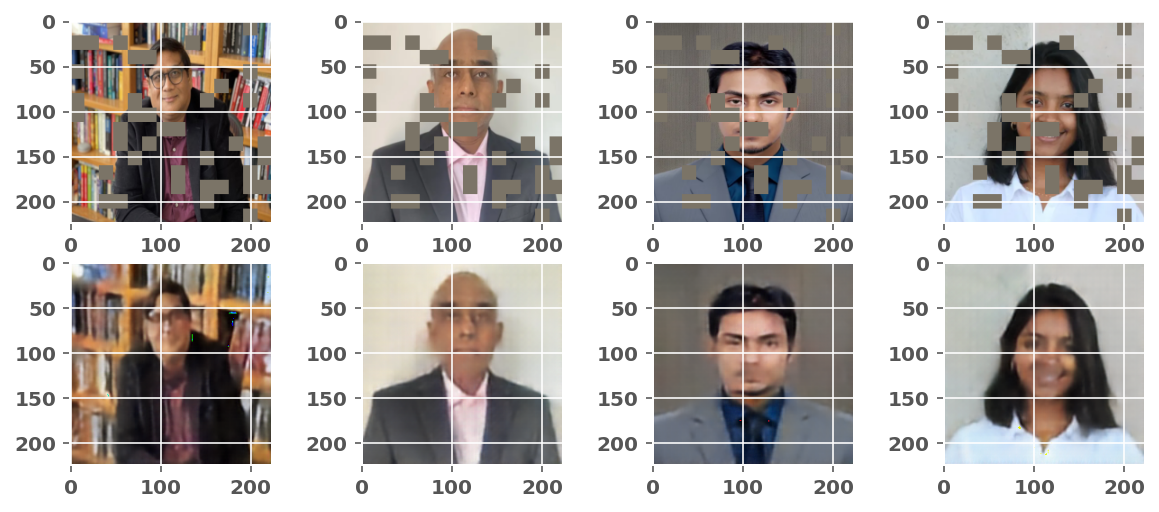

In [11]:
import matplotlib.pyplot as plt
from svlearn_autoencoders.auto_encoders.auto_encoder_util import convert
with torch.no_grad():
    num_images = len(images)
    images = [img.to(device) for img in images]
    images = torch.stack(images)
    reconstructed, _ = model(images)
    
    # Display original and reconstructed images
    _, axs = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        axs[0, i].imshow(convert(images[i].cpu()))
        axs[1, i].imshow(convert(reconstructed[i].cpu()))
    plt.show()